
##### NOW GENERATING DATA POINTS... #####


##### NOW ASSIGNING CLASSES TO DATA POINTS... #####

Class 0: 115 nodes
Class 1: 126 nodes
Class 2: 110 nodes
Class 3: 149 nodes

##### NOW MASKING TRAINING, VALIDATING, AND TESTING NODES... #####

Train set: 196 nodes
Validation set: 0 nodes
Test set: 304 nodes
Epoch: 0	| Loss |   Tr: 1.527814
		|  Acc |   Tr: 29.5918%

------------------------- STARTED LEARNING --------------------------

Epoch: 20	| Loss |   Tr: 0.254826
		|  Acc |   Tr: 86.2245%
Epoch: 40	| Loss |   Tr: 0.003573
		|  Acc |   Tr: 100.0000%
Epoch: 60	| Loss |   Tr: 0.000885
		|  Acc |   Tr: 100.0000%
Epoch: 80	| Loss |   Tr: 0.000562
		|  Acc |   Tr: 100.0000%
Epoch: 100	| Loss |   Tr: 0.000464
		|  Acc |   Tr: 100.0000%
Epoch: 120	| Loss |   Tr: 0.000409
		|  Acc |   Tr: 100.0000%
Epoch: 140	| Loss |   Tr: 0.000367
		|  Acc |   Tr: 100.0000%
Epoch: 160	| Loss |   Tr: 0.000333
		|  Acc |   Tr: 100.0000%
Epoch: 180	| Loss |   Tr: 0.000304
		|  Acc |   Tr: 100.0000%
Epoch: 2

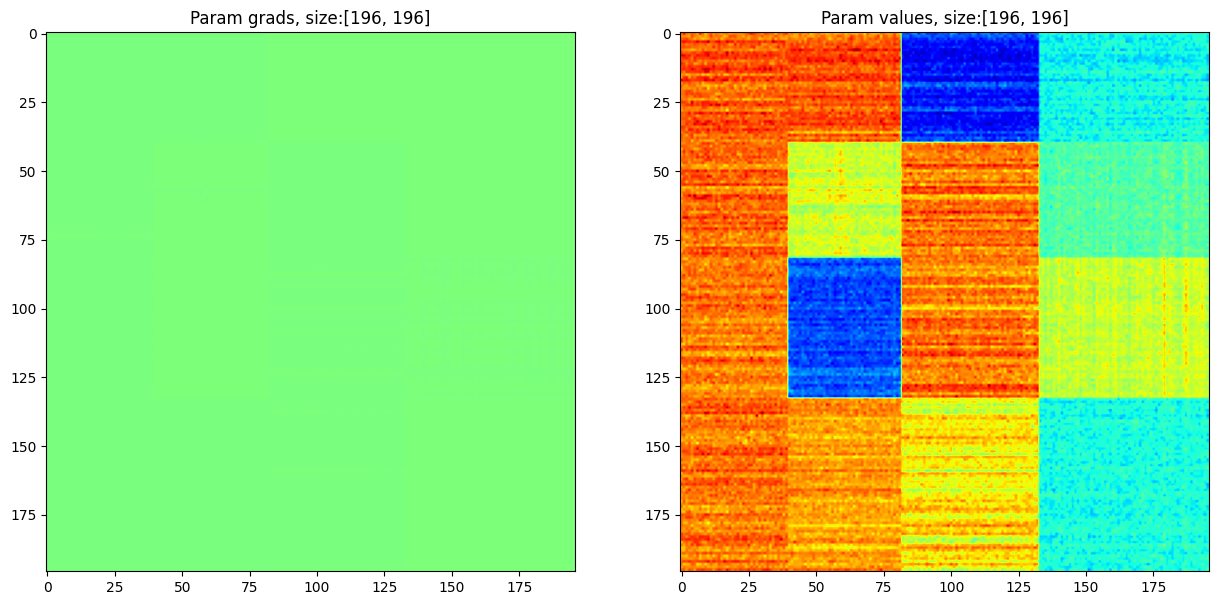

In [1]:
import os
clc = lambda: os.system('cls')
cwd = os.getcwd()
desktop = "C:/Users/echo_/Desktop/"
import torch_utils as utils
from torch_utils import pipeline, task, monitor, datatool, auxs
import torch as t
import torch.nn.functional as F
from torch.nn.parameter import Parameter as P
import numpy as np
import matplotlib.pyplot as plt
from math import nan
D = datatool.my_data_generator(p_train=0.4, p_test=0.6, remainder_twist=True)
D.load_cuda()
#--------------------------------------------------------------------------------------------------#
# A leaning idea 1

class NodeClassifier(t.nn.Module):
    def __init__(self, seed, D, hidden_channels, A):
        super().__init__()
        self.D = D
        self.A = P(A)
        t.manual_seed(seed); 
        self.W0 = P(t.randn(hidden_channels,D.num_features))
        self.b0 = P(t.randn(hidden_channels,1))
        self.W1 = P(t.randn(D.num_classes,hidden_channels))
        self.b1 = P(t.randn(D.num_classes,1))
        self.params = list(self.parameters())
        self.n_params = len(self.params)
    def forward(self, x):
        x = t.tensordot(x,self.A,dims=[[1],[0]])
        x = t.tensordot(self.W0,x,dims=[[1],[0]])+self.b0
        #x = F.dropout(x,p=0.5,training=self.training)
        x = t.sigmoid(x)
        x = t.tensordot(x,self.A,dims=[[1],[0]])
        x = t.tensordot(self.W1,x,dims=[[1],[0]])+self.b1
        return t.transpose(x,0,1)

class NodeClassifier_test(t.nn.Module):
    def __init__(self, A):
        super().__init__()
        self.A = A
        self.W0 = node_train_model.W0
        self.b0 = node_train_model.b0
        self.W1 = node_train_model.W1
        self.b1 = node_train_model.b1
        self.params = [self.A,self.W0,self.b0,self.W1,self.b1]
    def forward(self, x):
        x = t.tensordot(x,self.A,dims=[[1],[0]])
        x = t.tensordot(self.W0,x,dims=[[1],[0]])+self.b0
        x = F.sigmoid(x)
        x = t.tensordot(x,self.A,dims=[[1],[0]])
        x = t.tensordot(self.W1,x,dims=[[1],[0]])+self.b1
        return t.transpose(x,0,1)


seed = 1; t.manual_seed(seed)
Adj = 0.01*t.randn(D.num_train,D.num_train,device=0)
node_train_model =  NodeClassifier(seed,D,hidden_channels=8,A=Adj).cuda()
result = pipeline.BasicLearn(
    model = node_train_model,
    D = D,
    criterion = t.nn.CrossEntropyLoss(),
    optimizer = t.optim.Adam(node_train_model.parameters(), lr=5e-3, weight_decay=1e-5),
    total_epoch = 1200,
    train_x = t.transpose(D.x[D.train_mask],0,1), 
    train_y = D.y[D.train_mask],
    tasklist = [ 
                (task.Prog.loss_basic, 1), # int: per | nan: only at start & end
                (task.Prog.acc_maskwise, 1),
                (monitor.Prog.loss_log, 20),
                (monitor.Prog.acc_log, 20),
                (monitor.Prog.LA_plot, 100),
                (task.Param.P_max_mean, 20),
                (monitor.Param.P_max_mean_log, 100),
                (monitor.Param.P_max_mean_window, 100),
                (monitor.X.out_2d, nan),
                (monitor.Param.P_show, nan),
              ],
    save_dir = f"{cwd}/results_node_train_0_cuda",
    )

print(f"Best fitting Adj: {node_train_model.A}")

utils.P_draw(node_train_model.A,size=(15,7)); plt.show()

In [10]:
etm, evm, _, = \
    datatool.masker(D.num_train,p_train=0.7,p_val=0.3,p_test=0)


etm.cuda(); evm.cuda()
edge_y_tr = t.zeros(etm.sum(),etm.sum(), dtype=t.float, device=0)
edge_x_tr = t.zeros(etm.sum(),etm.sum(), 2*D.num_features, device=0)
edge_y_val = t.zeros(evm.sum(),evm.sum(), dtype=t.float, device=0)
edge_x_val = t.zeros(evm.sum(),evm.sum(), 2*D.num_features, device=0)
#D.unload_cuda()

target_A = 100*node_train_model.A
for i in range(0,etm.sum()):
    for j in range(0,etm.sum()):
        edge_y_tr[i,j] = target_A[etm][:,etm][i,j].item()
        edge_x_tr[i,j,:] = t.cat( (D.x[D.train_mask][etm][i,:],D.x[D.train_mask][etm][j,:]), dim=0 )

for i in range(0,evm.sum()):
    for j in range(0,evm.sum()):
        edge_y_val[i,j] = target_A[evm][:,evm][i,j].item()
        edge_x_val[i,j,:] = t.cat( (D.x[D.train_mask][evm][i,:],D.x[D.train_mask][evm][j,:]), dim=0 )

edge_x_tr = edge_x_tr.view(-1,2*D.num_features)
edge_y_tr = edge_y_tr.view(-1,)
edge_x_val = edge_x_val.view(-1,2*D.num_features)
edge_y_val = edge_y_val.view(-1,)
# reg_y = t.zeros(D.num_train,D.num_train,device=0)
# reg_x = t.zeros(D.num_train,D.num_train,2*D.num_features,device=0)
# #D.unload_cuda()
# A = node_train_model.A
# for i in range(0,D.num_train):
#   for j in range(0,D.num_train):
#     reg_y[i,j] = 100*A[i,j].item()
#     reg_x[i,j,:] = t.cat( (D.x[D.train_mask][i,:],D.x[D.train_mask][j,:]), dim=0 )

Train set: 136 nodes
Validation set: 60 nodes
Test set: 0 nodes


Epoch: 0	| Loss |   Tr: 42.069984   Val: 41.941010


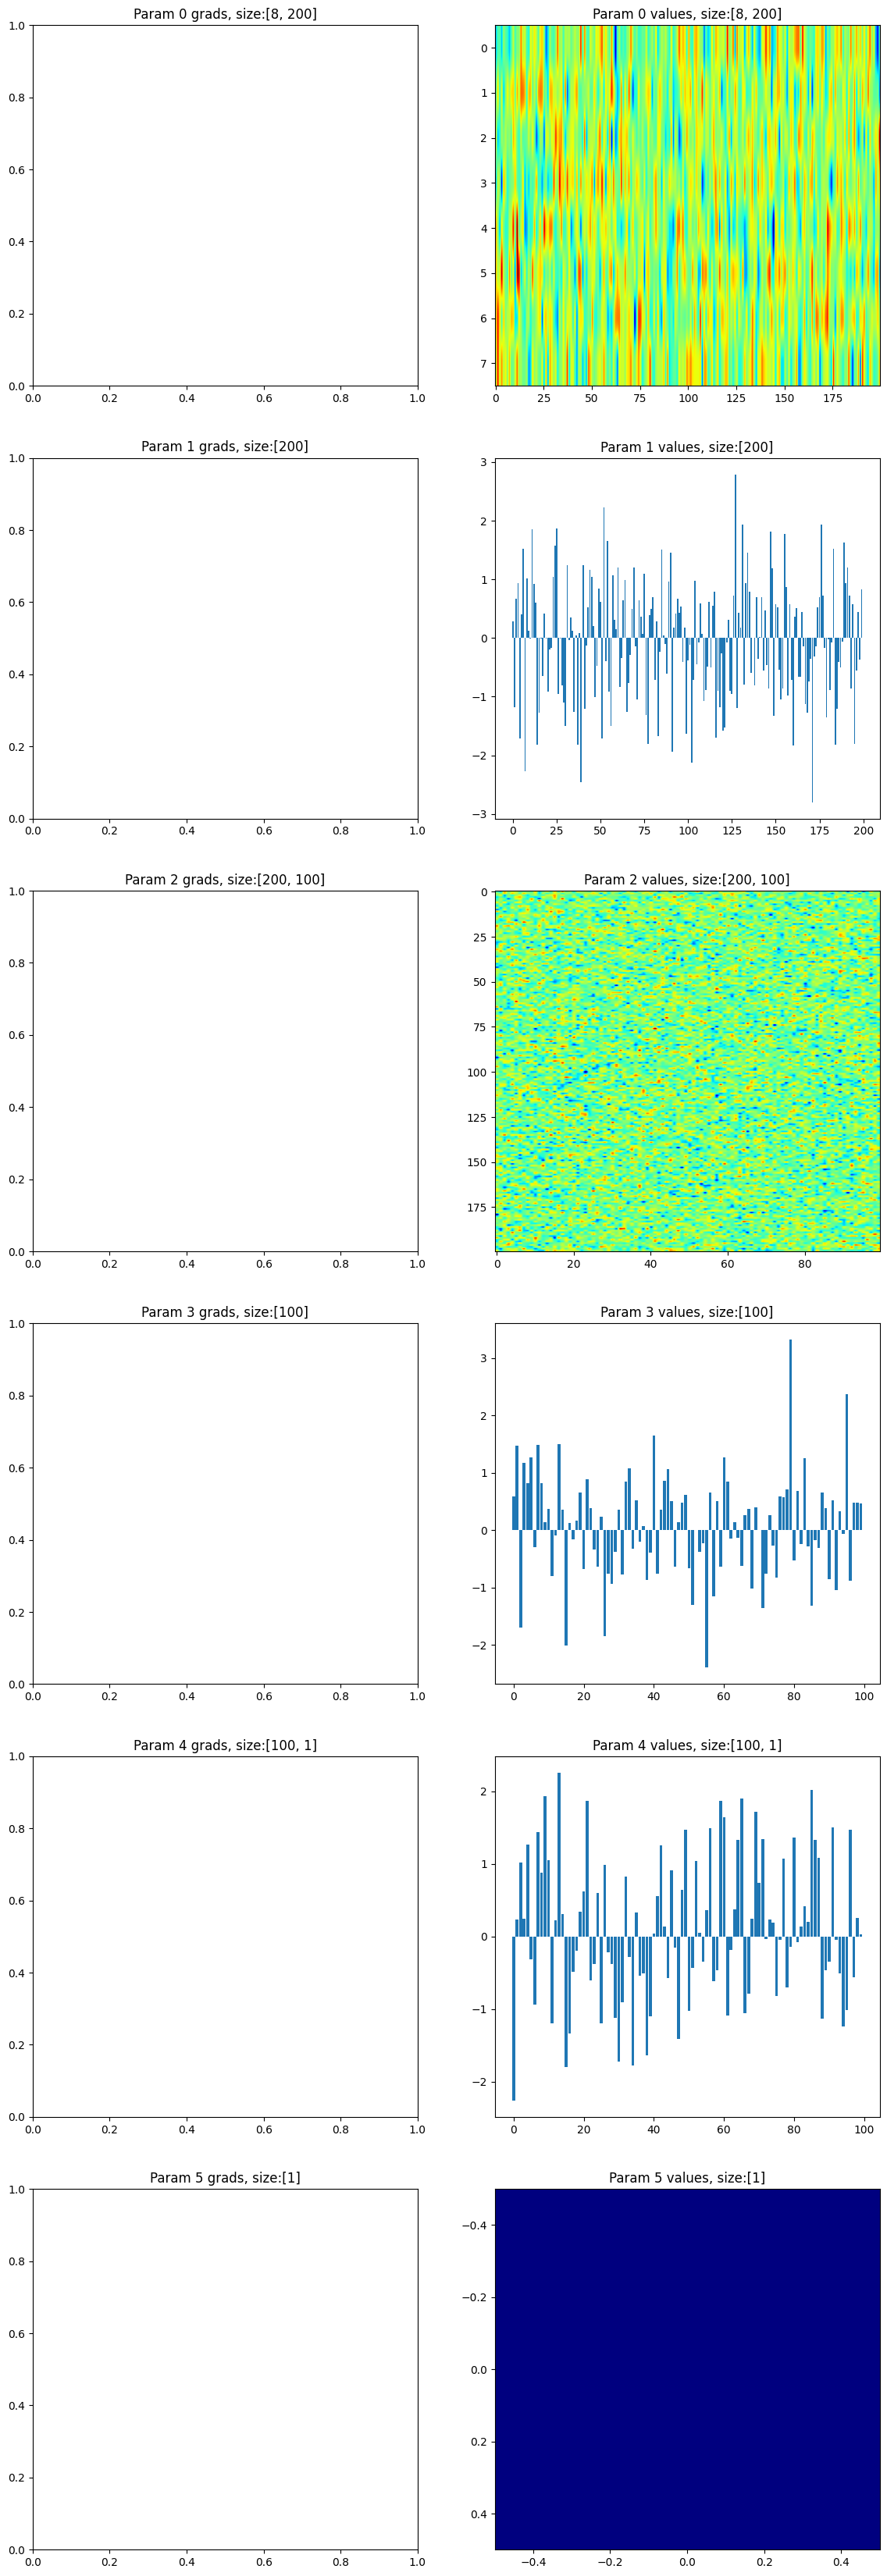


------------------------- STARTED LEARNING --------------------------

Epoch: 20	| Loss |   Tr: 27.318718   Val: 29.975473
Epoch: 40	| Loss |   Tr: 26.253084   Val: 28.692223
Epoch: 60	| Loss |   Tr: 26.002323   Val: 28.383396
Epoch: 80	| Loss |   Tr: 25.857319   Val: 28.460382
Epoch: 100	| Loss |   Tr: 25.666388   Val: 28.646772
Epoch: 120	| Loss |   Tr: 25.498400   Val: 28.718216
Epoch: 140	| Loss |   Tr: 25.368788   Val: 28.843288
Epoch: 160	| Loss |   Tr: 25.226805   Val: 29.137182
Epoch: 180	| Loss |   Tr: 25.080177   Val: 29.231380
Epoch: 200	| Loss |   Tr: 24.926140   Val: 29.369284
Epoch: 220	| Loss |   Tr: 24.761358   Val: 29.680574
Epoch: 240	| Loss |   Tr: 24.568655   Val: 29.869421
Epoch: 260	| Loss |   Tr: 24.367382   Val: 29.972319
Epoch: 280	| Loss |   Tr: 24.108061   Val: 30.341742
Epoch: 300	| Loss |   Tr: 23.873369   Val: 30.640339
Epoch: 320	| Loss |   Tr: 23.650862   Val: 30.998850
Epoch: 340	| Loss |   Tr: 23.439821   Val: 31.373278
Epoch: 360	| Loss |   Tr: 23.24

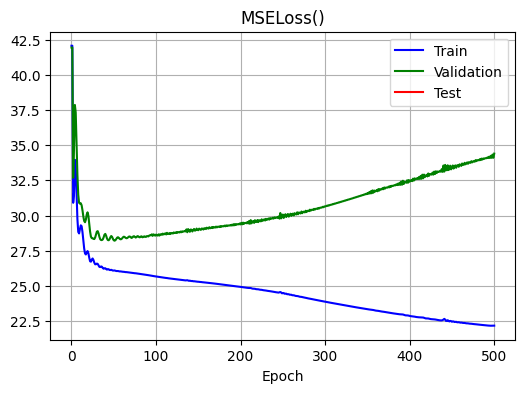

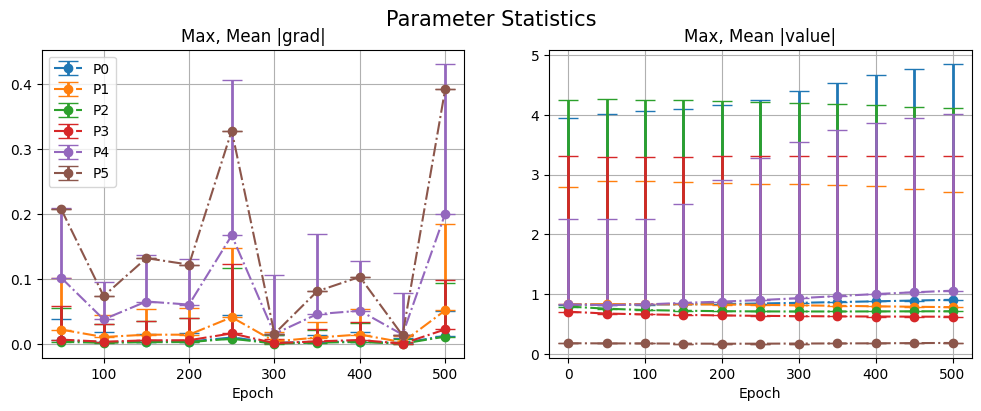

Epoch: 520	| Loss |   Tr: 22.013672   Val: 34.477940
Epoch: 540	| Loss |   Tr: 22.011866   Val: 35.078526
Epoch: 560	| Loss |   Tr: 21.790968   Val: 34.937424
Epoch: 580	| Loss |   Tr: 21.681370   Val: 35.171616
Epoch: 600	| Loss |   Tr: 21.572287   Val: 35.440952
Epoch: 620	| Loss |   Tr: 21.464190   Val: 35.656586
Epoch: 640	| Loss |   Tr: 21.357122   Val: 35.878132
Epoch: 660	| Loss |   Tr: 21.256174   Val: 36.082592
Epoch: 680	| Loss |   Tr: 21.158770   Val: 36.269032
Epoch: 700	| Loss |   Tr: 21.058233   Val: 36.504238
Epoch: 720	| Loss |   Tr: 20.974203   Val: 36.589558
Epoch: 740	| Loss |   Tr: 20.873022   Val: 36.773335
Epoch: 760	| Loss |   Tr: 20.820780   Val: 37.203789
Epoch: 780	| Loss |   Tr: 20.692204   Val: 37.208035
Epoch: 800	| Loss |   Tr: 20.596004   Val: 37.243725
Epoch: 820	| Loss |   Tr: 20.514919   Val: 37.337440
Epoch: 840	| Loss |   Tr: 20.425114   Val: 37.511787
Epoch: 860	| Loss |   Tr: 20.334745   Val: 37.550541
Epoch: 880	| Loss |   Tr: 20.243437   Val: 37.

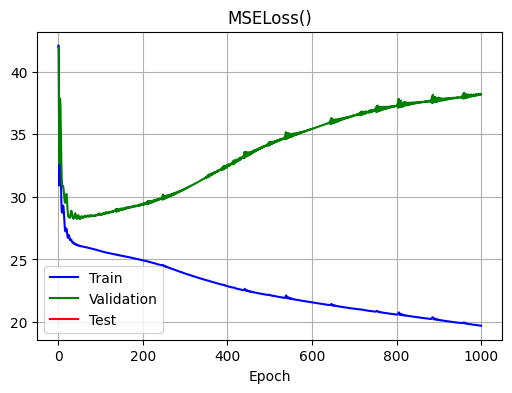

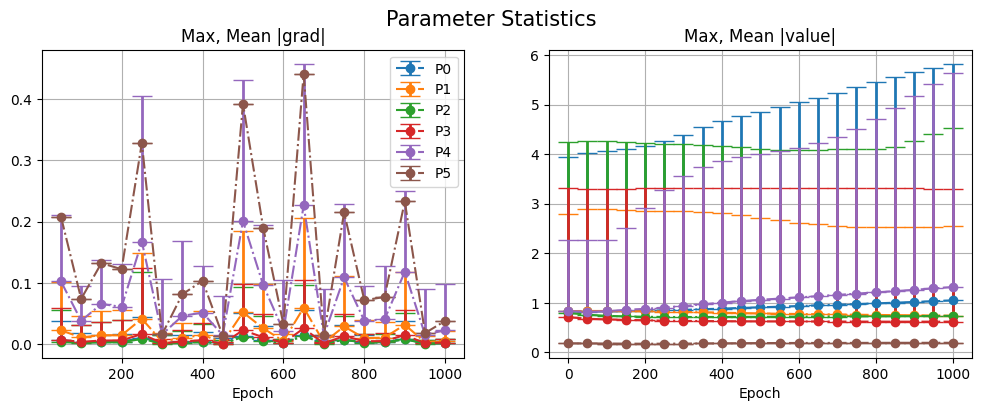

Epoch: 1020	| Loss |   Tr: 19.616165   Val: 38.285149
Epoch: 1040	| Loss |   Tr: 19.543982   Val: 38.327145
Epoch: 1060	| Loss |   Tr: 19.444471   Val: 38.503433
Epoch: 1080	| Loss |   Tr: 19.356750   Val: 38.636440
Epoch: 1100	| Loss |   Tr: 19.272215   Val: 38.828728
Epoch: 1120	| Loss |   Tr: 19.195051   Val: 38.981483
Epoch: 1140	| Loss |   Tr: 19.102118   Val: 39.025364
Epoch: 1160	| Loss |   Tr: 19.014469   Val: 39.166241
Epoch: 1180	| Loss |   Tr: 18.933041   Val: 39.316372
Epoch: 1200	| Loss |   Tr: 18.846352   Val: 39.533154
Epoch: 1220	| Loss |   Tr: 18.760231   Val: 39.681942
Epoch: 1240	| Loss |   Tr: 18.687639   Val: 39.944935
Epoch: 1260	| Loss |   Tr: 18.603033   Val: 40.142830
Epoch: 1280	| Loss |   Tr: 18.517517   Val: 40.199242
Epoch: 1300	| Loss |   Tr: 18.430826   Val: 40.387398
Epoch: 1320	| Loss |   Tr: 18.339983   Val: 40.604130
Epoch: 1340	| Loss |   Tr: 18.287422   Val: 40.988377
Epoch: 1360	| Loss |   Tr: 18.178032   Val: 40.991295
Epoch: 1380	| Loss |   Tr: 1

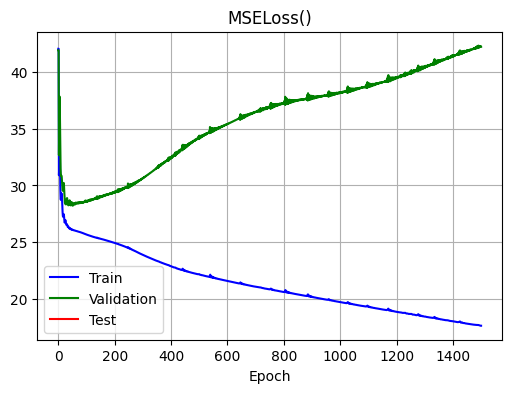

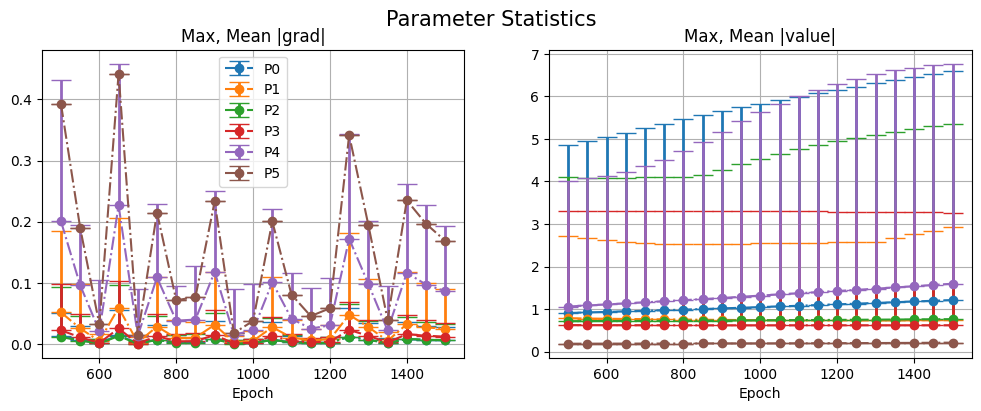

Epoch: 1520	| Loss |   Tr: 17.540154   Val: 42.470226
Epoch: 1540	| Loss |   Tr: 17.465469   Val: 42.607769
Epoch: 1560	| Loss |   Tr: 17.402470   Val: 42.816181
Epoch: 1580	| Loss |   Tr: 17.325975   Val: 42.903389
Epoch: 1600	| Loss |   Tr: 17.292582   Val: 43.177666
Epoch: 1620	| Loss |   Tr: 17.186092   Val: 43.245869
Epoch: 1640	| Loss |   Tr: 17.113075   Val: 43.383015
Epoch: 1660	| Loss |   Tr: 17.076601   Val: 43.618332
Epoch: 1680	| Loss |   Tr: 16.979689   Val: 43.669621
Epoch: 1700	| Loss |   Tr: 16.917221   Val: 43.809669
Epoch: 1720	| Loss |   Tr: 16.846096   Val: 43.963951
Epoch: 1740	| Loss |   Tr: 16.780331   Val: 44.098663
Epoch: 1760	| Loss |   Tr: 16.713751   Val: 44.258900
Epoch: 1780	| Loss |   Tr: 16.650013   Val: 44.402367
Epoch: 1800	| Loss |   Tr: 16.620440   Val: 44.555088
Epoch: 1820	| Loss |   Tr: 16.536774   Val: 44.753334
Epoch: 1840	| Loss |   Tr: 16.462942   Val: 44.843445
Epoch: 1860	| Loss |   Tr: 16.409697   Val: 44.998699
Epoch: 1880	| Loss |   Tr: 1

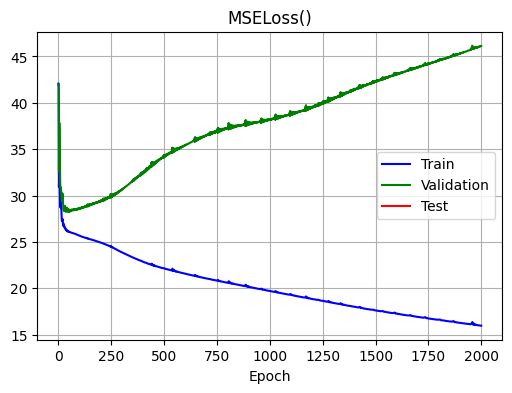

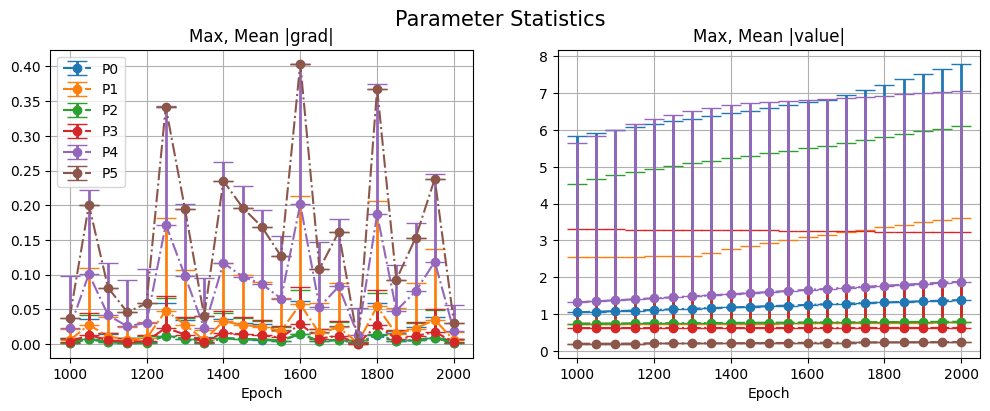

Epoch: 2020	| Loss |   Tr: 15.907839   Val: 46.296711
Epoch: 2040	| Loss |   Tr: 15.849455   Val: 46.466736
Epoch: 2060	| Loss |   Tr: 15.790305   Val: 46.642338
Epoch: 2080	| Loss |   Tr: 15.964859   Val: 47.031658
Epoch: 2100	| Loss |   Tr: 15.704291   Val: 47.017277
Epoch: 2120	| Loss |   Tr: 15.620729   Val: 47.150089
Epoch: 2140	| Loss |   Tr: 15.562815   Val: 47.325272
Epoch: 2160	| Loss |   Tr: 15.505927   Val: 47.503403
Epoch: 2180	| Loss |   Tr: 15.450392   Val: 47.685913
Epoch: 2200	| Loss |   Tr: 15.502890   Val: 48.035240
Epoch: 2220	| Loss |   Tr: 15.363806   Val: 48.035053
Epoch: 2240	| Loss |   Tr: 15.297551   Val: 48.204903
Epoch: 2260	| Loss |   Tr: 15.244925   Val: 48.376003
Epoch: 2280	| Loss |   Tr: 15.194718   Val: 48.545029
Epoch: 2300	| Loss |   Tr: 15.144888   Val: 48.714516
Epoch: 2320	| Loss |   Tr: 15.102088   Val: 48.890533
Epoch: 2340	| Loss |   Tr: 15.084236   Val: 49.072880
Epoch: 2360	| Loss |   Tr: 15.009388   Val: 49.205341

---------------------- TERM

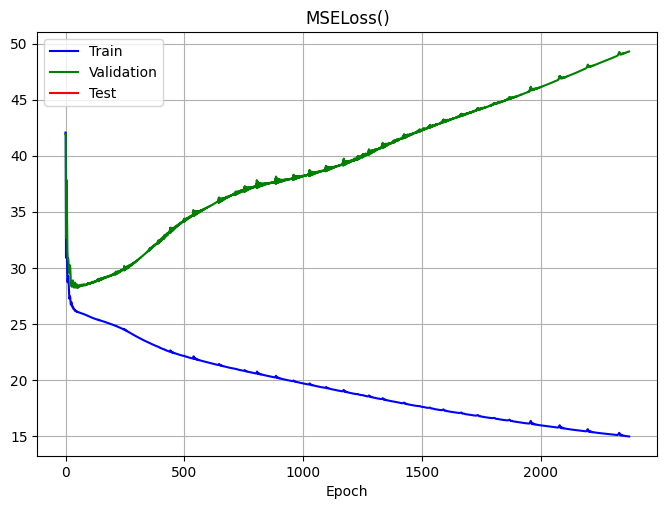

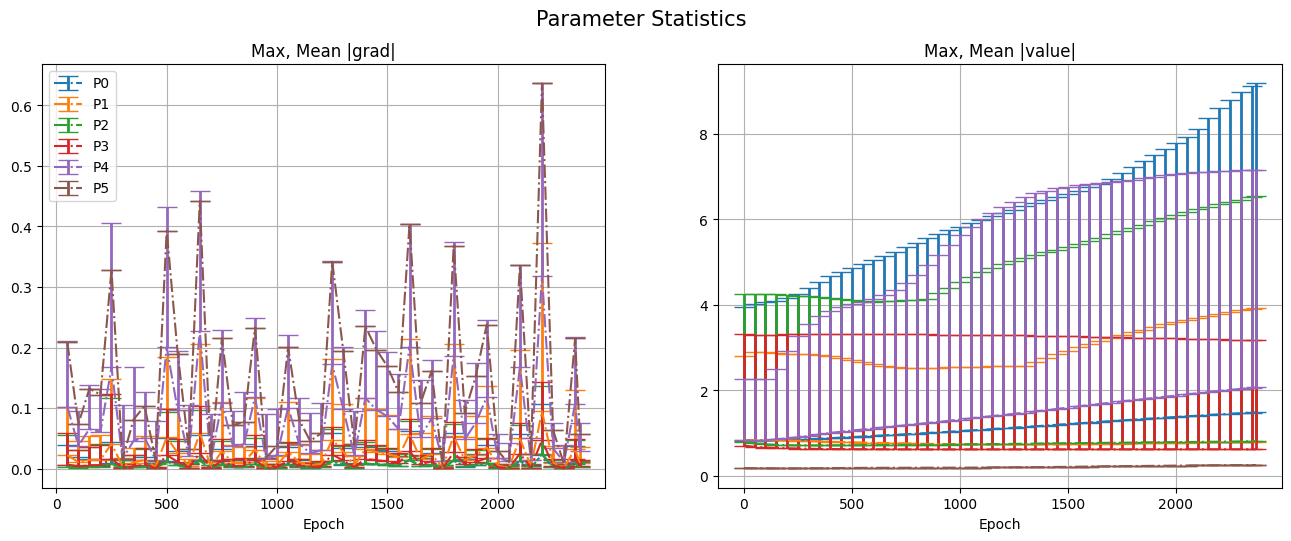

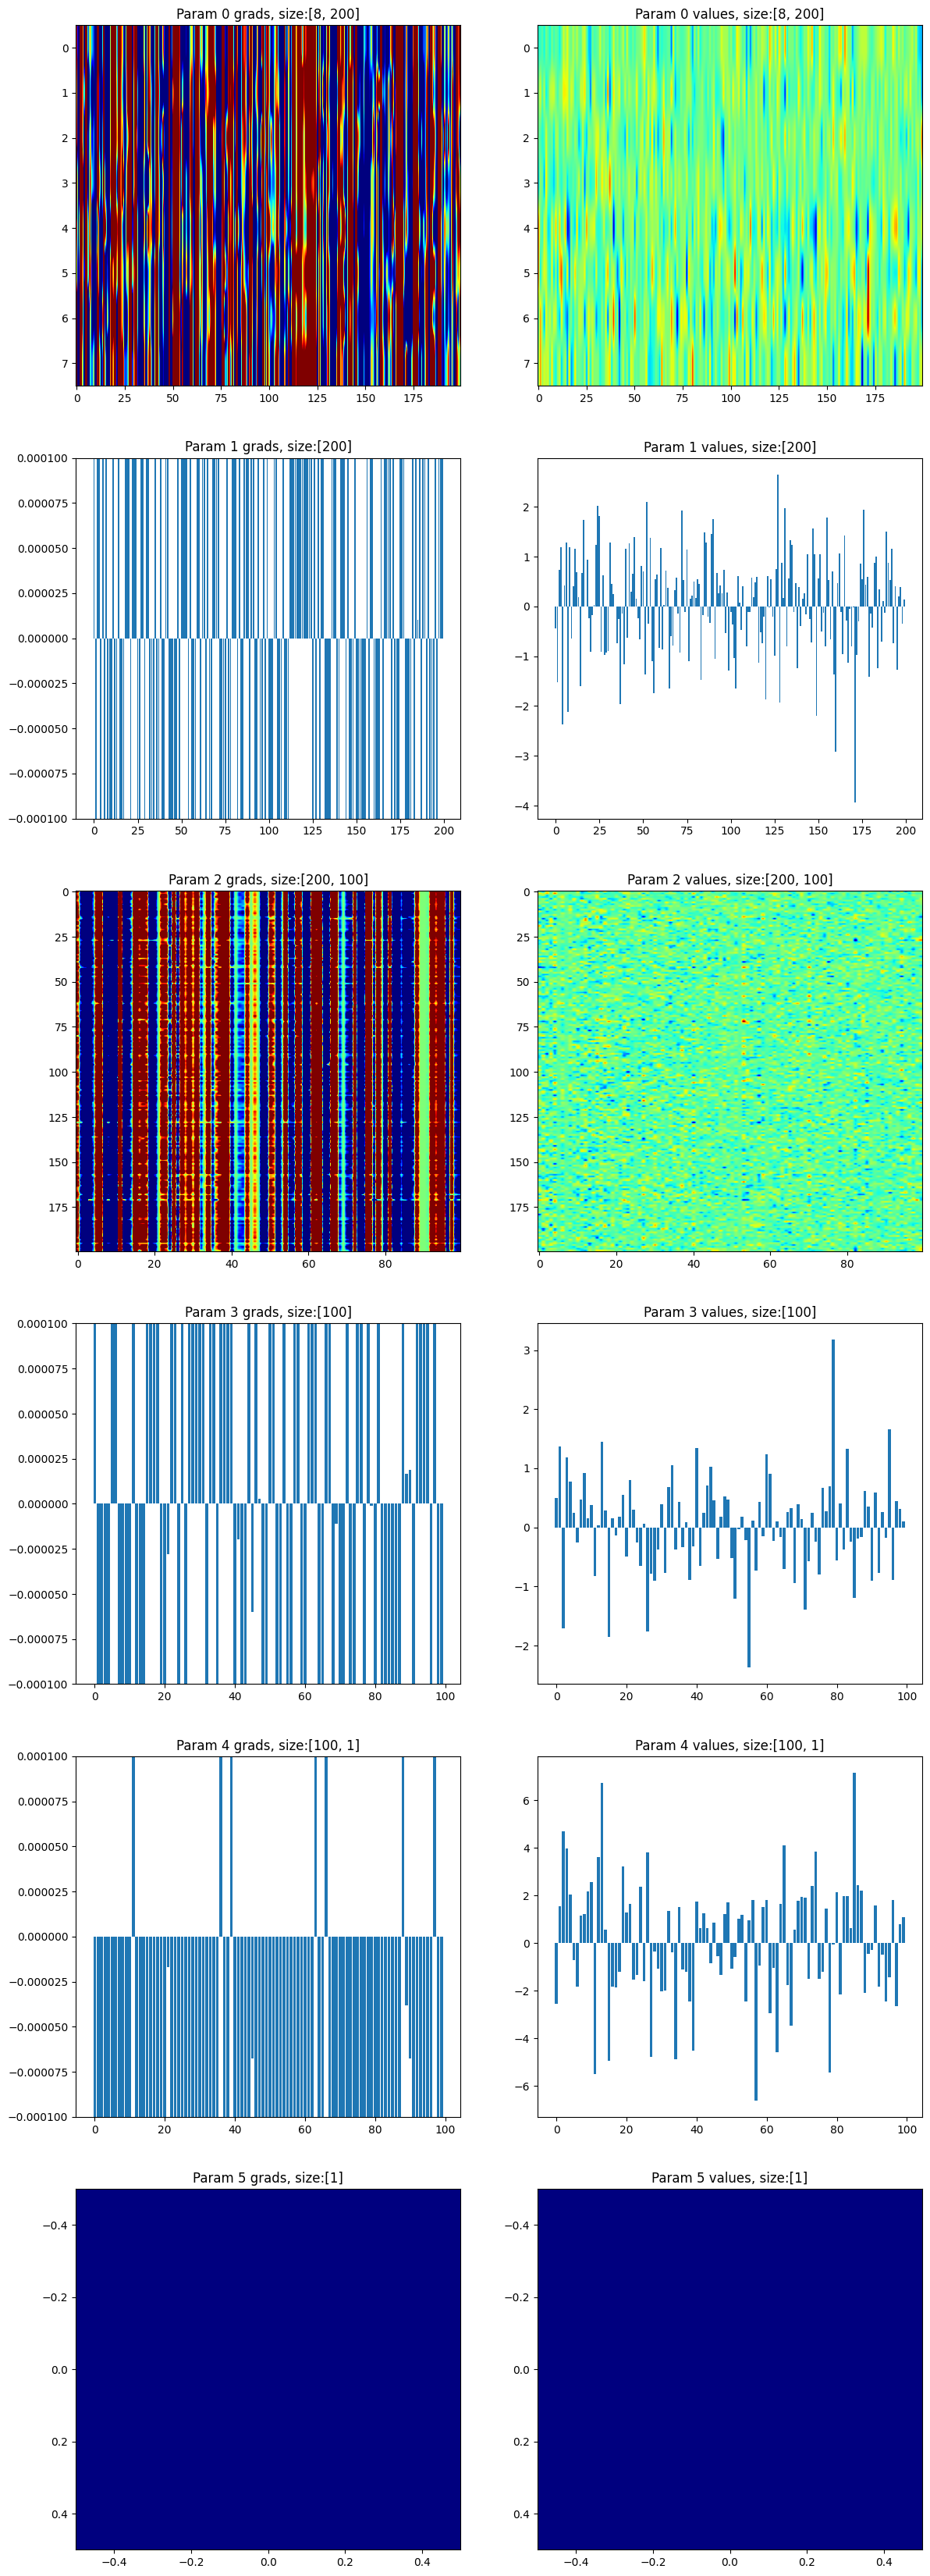

In [12]:
class WeightPredictor(t.nn.Module):
    def __init__(self,seed,reg_x,hidden_channels):
        super().__init__()
        t.manual_seed(seed); 
        self.W0 = P(t.randn(reg_x.shape[1],hidden_channels[0]))
        self.b0 = P(t.randn(hidden_channels[0]))
        self.W1 = P(t.randn(hidden_channels[0],hidden_channels[1]))
        self.b1 = P(t.randn(hidden_channels[1]))
        self.W2 = P(t.randn(hidden_channels[1],1))
        self.b2 = P(t.randn(1))
        self.params = list(self.parameters())
        self.n_params = len(self.params)
    def forward(self, x):
        x = t.tensordot(x,self.W0,dims=[[1],[0]])+self.b0
        #x = F.dropout(x,p=0.5,training=self.training)
        x = t.sigmoid(x)
        x = t.tensordot(x,self.W1,dims=[[1],[0]])+self.b1
        #x = F.dropout(x,p=0.5,training=self.training)
        x = t.sigmoid(x)
        x = t.tensordot(x,self.W2,dims=[[1],[0]])+self.b2
        return x
# experiment 1

edge_train_model = WeightPredictor(seed, edge_x_tr, hidden_channels=[200,100] ).cuda()
criterion = t.nn.MSELoss()
optimizer = t.optim.Adam(edge_train_model.parameters(), lr=5e-3, weight_decay=1e-5)
total_epoch = 100000

train_x = edge_x_tr; train_y = edge_y_tr



val_x=edge_x_val; val_y=edge_y_val; test_x=[]; test_y=[]
tasklist = [ 
            (task.Prog.loss_basic, 1), # int: per | nan: only at end
            (monitor.Prog.loss_log, 20),
            (monitor.Prog.LA_plot, 500),
            (task.Param.P_max_mean, 50),
            #(monitor.Param.P_max_mean_log, 1e10),
            (monitor.Param.P_max_mean_window, 500),
            (monitor.Param.P_show, 1e10),
            ]

streaming = True
#save_dir = f"{cwd}/results_edge_train0"

save_dir = False
result = pipeline.BasicLearn(edge_train_model,D,criterion,optimizer,total_epoch,train_x,train_y,
                             tasklist,val_x,val_y,test_x,test_y,streaming,save_dir)